In [122]:
%matplotlib inline
import importlib
import numpy as np
import pandas as pd
import churn_analysis as churn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
#from functions import *
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

In [123]:
df_creditdata = pd.read_csv("Credit Data.csv")

In [125]:
df_creditdata.head()

,Default,TA,TDE16,TDE17,TDyoy,TDC16,TDC17,TDCyoy,UFCF16,UFCF17,UFCFyoy,IE16,IE17,IEyoy,OLC516,OLC517,OLCyoy,EB16,EB17,EByoy
0,0.0,1.68,NaN,1.5,NaN,NaN,1.48,NaN,0.20,0.86,0.66,0.10,NaN,NaN,NaN,NaN,NaN,0.14,0.10,-0.04
1,0.0,1.94,NaN,NaN,NaN,359.0,433.50,74.5,0.47,0.43,-0.04,0.16,0.21,0.05,1.37,1.96,0.59,0.24,0.10,-0.14
2,0.0,2.40,NaN,112.8,NaN,114.7,53.00,-61.7,0.15,0.47,0.32,0.86,0.77,-0.09,NaN,NaN,NaN,0.40,0.10,-0.30
3,0.0,0.11,NaN,NaN,NaN,116.1,NaN,NaN,0.91,NaN,NaN,0.30,0.30,0.00,NaN,NaN,NaN,0.34,0.11,-0.23
4,0.0,1.80,23.5,35.6,12.1,19.0,26.30,7.3,0.59,0.23,-0.36,0.15,0.70,0.55,NaN,NaN,NaN,0.34,0.11,-0.23


In [97]:
def split_data(X,y,x_proportion = 0.8):
    '''
    We split data in X_train, y_train, X_test, y_test
    where X_train has balanced number of 0 label and 1 label
    
    return:
    X_train, y_train, X_test, y_test
    '''
    y = pd.DataFrame(y)
    y.columns = ['Default']
    positive_idx = y.index[y['Default'] == 1].tolist()
    negative_idx = y.index[y['Default'] == 0].tolist()
    
    # take 90% of positive label data into training set
    # take 600 of 0 label data into training set 
    
    pos_idx_split = int(len(positive_idx)*x_proportion)
    neg_idx_split = pos_idx_split + 100

    train_y_idx = positive_idx[:pos_idx_split] + negative_idx[:neg_idx_split]
    test_y_idx = positive_idx[pos_idx_split:] + negative_idx[neg_idx_split:]
    
    np.random.shuffle(train_y_idx)
    np.random.shuffle(test_y_idx)
    
    X_train = X.loc[train_y_idx]
    y_train = y['Default'][train_y_idx]
    X_test = X.loc[test_y_idx] 
    y_test = y['Default'][test_y_idx]
    
    return X_train,y_train,X_test,y_test


def impute_dataset_with_mean(train_X,test_X):
    '''
    train_X:  training data features
    test_X:  test data features
    
    return:
    normalized_train_X: normalized train data and with missing value imputed by column mean 
    normalized_test_X: normalized test data and with missing value imputed by training data stats
    scalar: contain the scalar information for our trained dataset, use scalar.transform to transform test set and
    run evaluation
    '''
    # fit the standard scalar with train data 
    scaler = StandardScaler()
    scaler.fit(train_X)
    # normalize train data 
    normalized_train_X = scaler.transform(train_X)
    normalized_train_X = pd.DataFrame(normalized_train_X)
    normalized_train_X.columns = train_X.columns
    
    # normalize test data using train data stats 
    normalized_test_X = scaler.transform(test_X)
    normalized_test_X = pd.DataFrame(normalized_test_X)
    normalized_test_X.columns = test_X.columns
    
    for col in normalized_train_X.columns:
        normalized_train_X[col].fillna((normalized_train_X[col].median()), inplace=True)
        normalized_test_X[col].fillna((normalized_test_X[col].median()), inplace=True)
        

    return normalized_train_X,normalized_test_X, scaler

# Descriptive Statistics

In [77]:
print (df_creditdata.shape)
print (df_creditdata.dtypes)

(4208, 20)
Default    float64
TA         float64
TDE16      float64
TDE17      float64
TDyoy      float64
TDC16      float64
TDC17      float64
TDCyoy     float64
UFCF16     float64
UFCF17     float64
UFCFyoy    float64
IE16       float64
IE17       float64
IEyoy      float64
OLC516     float64
OLC517     float64
OLCyoy     float64
EB16       float64
EB17       float64
EByoy      float64
dtype: object


In [78]:
print ("Percentage of Missing Values")
df_creditdata.isnull().sum()/df_creditdata.shape[0] * 100.0

Percentage of Missing Values


Default     0.023764
TA          1.188213
TDE16      31.273764
TDE17      31.939163
TDyoy      38.331749
TDC16      21.910646
TDC17      23.098859
TDCyoy     28.445817
UFCF16      3.730989
UFCF17      7.723384
UFCFyoy    10.123574
IE16        0.380228
IE17       10.052281
IEyoy      10.076046
OLC516     21.031369
OLC517     20.484791
OLCyoy     23.550380
EB16        7.200570
EB17       12.428707
EByoy      13.379278
dtype: float64

In [40]:
df_creditdata.groupby(by=["Default"]).count()

,TA,TDE16,TDE17,TDyoy,TDC16,TDC17,TDCyoy,UFCF16,UFCF17,UFCFyoy,IE16,IE17,IEyoy,OLC516,OLC517,OLCyoy,EB16,EB17,EByoy
Default,,,,,,,,,,,,,,,,,,,
0.0,3613,2409,2388,2131,2745,2697,2474,3515,3354,3253,3661,3260,3260,2787,2810,2682,3371,3158,3118
1.0,544,482,475,463,540,538,536,535,528,528,530,524,523,535,535,534,533,526,526


In [41]:
null_percentage_nodefault = df_creditdata[df_creditdata.Default == 0].isnull().sum() / df_creditdata[df_creditdata.Default == 0].shape[0]
null_percentage_default = df_creditdata[df_creditdata.Default == 1].isnull().sum() / df_creditdata[df_creditdata.Default == 1].shape[0]

In [42]:
# No Default more likely to have missing values

pd.DataFrame([null_percentage_default * 100, null_percentage_nodefault * 100],
            index =['Default Null Percentage', 'No Default Null Percentage'])

,Default,TA,TDE16,TDE17,TDyoy,TDC16,TDC17,TDCyoy,UFCF16,UFCF17,UFCFyoy,IE16,IE17,IEyoy,OLC516,OLC517,OLCyoy,EB16,EB17,EByoy
Default Null Percentage,0.0,0.366300,11.721612,13.003663,15.201465,1.098901,1.465201,1.831502,2.014652,3.296703,3.296703,2.930403,4.029304,4.212454,2.014652,2.014652,2.197802,2.380952,3.663004,3.663004
No Default Null Percentage,0.0,1.311117,34.198306,34.771920,41.791860,25.020486,26.331603,32.422835,3.987981,8.385687,11.144496,0.000000,10.953291,10.953291,23.873259,23.245015,26.741328,7.921333,13.739415,14.832013


In [43]:
df_stats = churn.getDfSummary(df_creditdata)
df_stats['count'] = df_creditdata.count()
df_stats

,mean,std,min,25%,50%,75%,max,missing,distinct,count
Default,0.129784,0.336105,0.00,0.000,0.000,0.000,1.0,1.0,2.0,4207
TA,4222.927732,30133.915386,0.10,5.850,84.950,853.450,851733.0,50.0,2868.0,4158
TDE16,129.569357,596.185011,0.12,13.875,41.300,96.400,19559.3,1316.0,1620.0,2892
TDE17,174.314113,1888.177719,0.11,13.775,41.050,95.825,93128.1,1344.0,1601.0,2864
TDyoy,39.559037,1608.977295,-13190.30,-17.800,-0.410,18.440,73568.8,1613.0,1662.0,2595
TDC16,104.335058,1172.103355,0.12,13.725,34.850,59.500,54222.8,922.0,1348.0,3286
TDC17,98.750701,1593.284134,0.11,14.000,35.150,58.000,79818.3,972.0,1312.0,3236
TDCyoy,5.790428,771.411430,-8477.70,-7.000,-0.340,7.800,40188.9,1197.0,1394.0,3011
UFCF16,239.288941,2156.840812,0.10,1.200,8.670,63.800,89548.9,157.0,1899.0,4051
UFCF17,216.351875,1266.792982,0.10,1.490,11.200,73.000,46157.9,325.0,1883.0,3883


# Variable Covariance

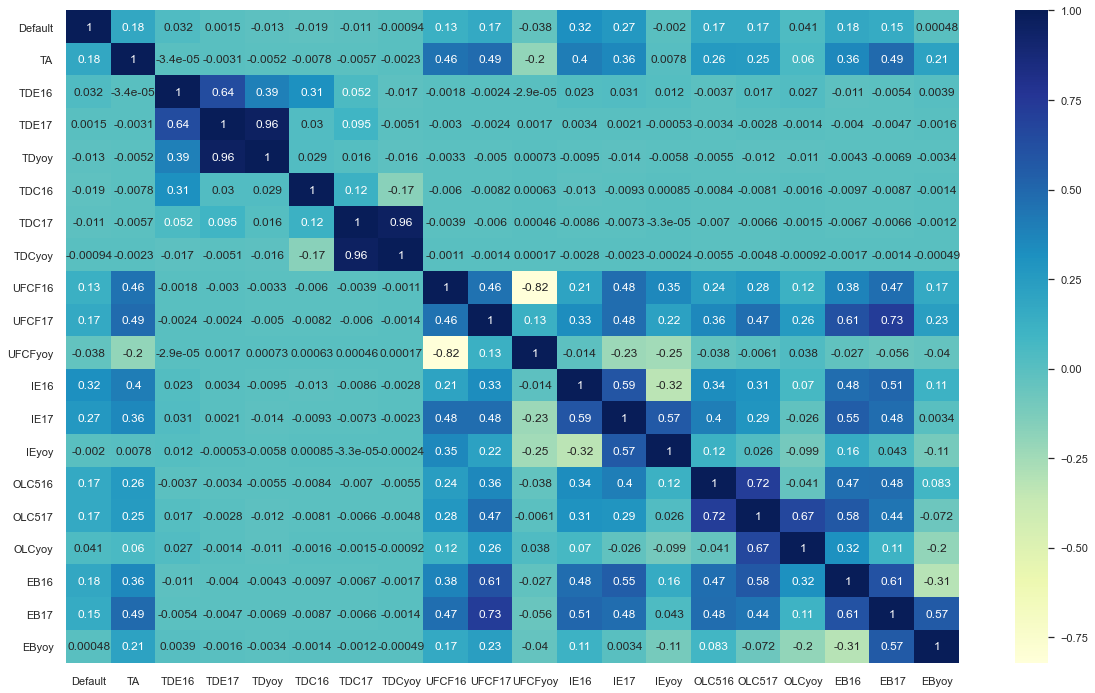

In [44]:
sns.set(rc={'figure.figsize':(20,12)})
corrMatrix = df_creditdata.corr()
sns.heatmap(corrMatrix, annot=True, cmap="YlGnBu")
plt.show()

In [45]:
import sklearn.feature_selection
from yellowbrick.target import FeatureCorrelation

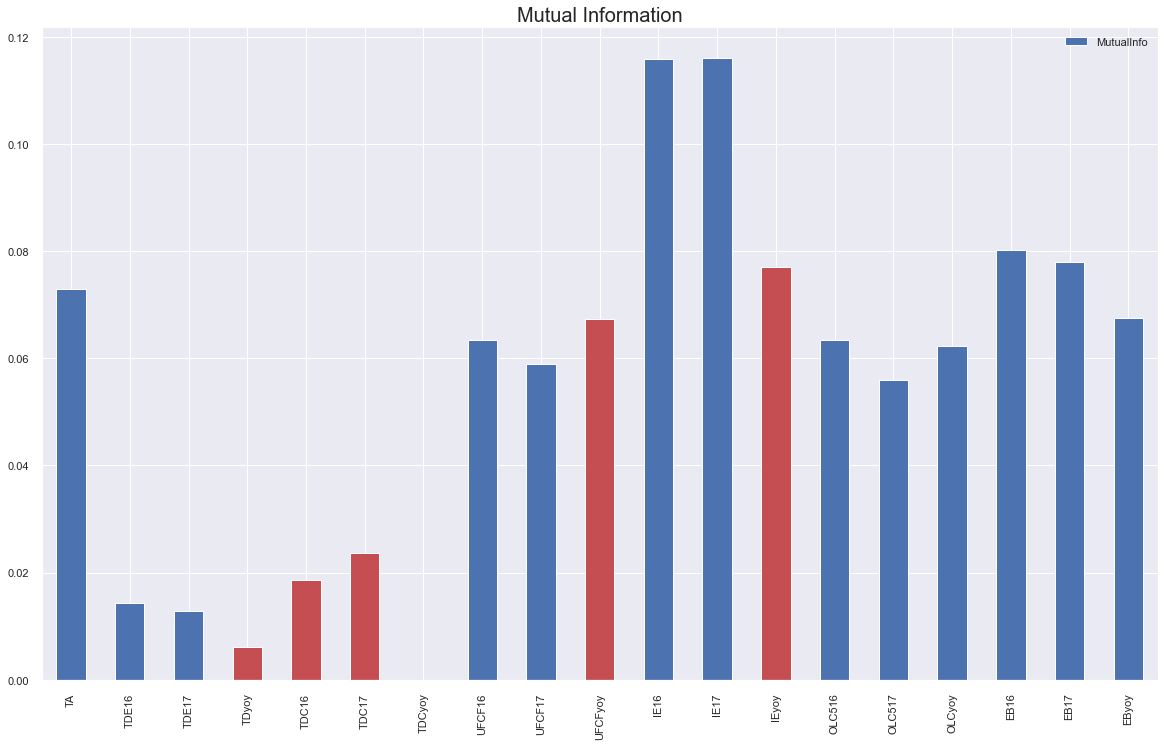

In [46]:
df_creditdata_nonan = df_creditdata.dropna()
X, y = df_creditdata_nonan.drop("Default", axis=1), df_creditdata_nonan[["Default"]]
features = np.array(df_creditdata_nonan.columns.drop('Default'))

mutual_info = sklearn.feature_selection.mutual_info_classif(X, y)
df_mutualinfo = pd.DataFrame([mutual_info, df_creditdata.corr()["Default"].drop("Default") > 0], columns=features).T
df_mutualinfo.columns = ["MutualInfo", "PositiveCorrelation"]

df_mutualinfo.plot.bar(color=[np.where(df_mutualinfo["PositiveCorrelation"] == True, 'b', 'r')])
plt.title('Mutual Information', size=20)
plt.show()

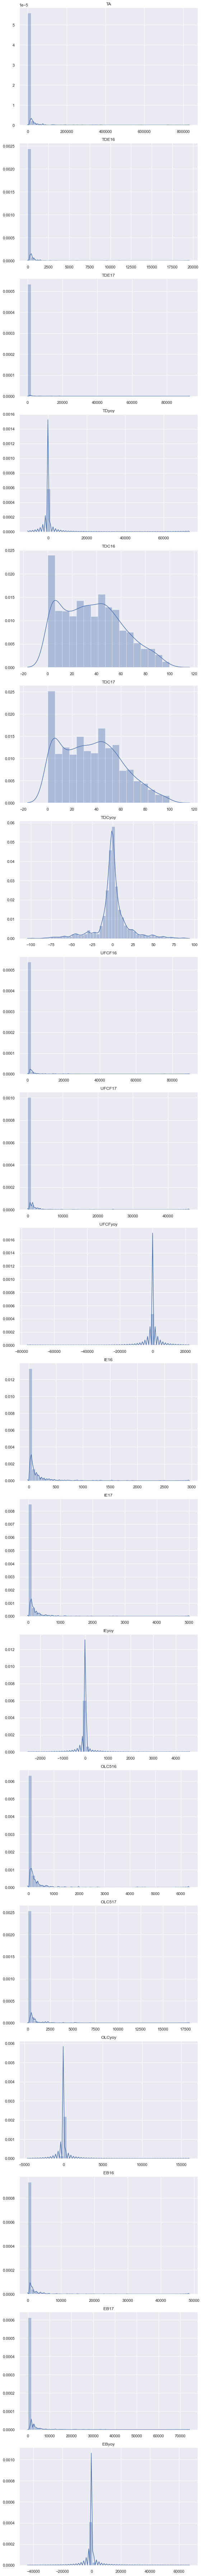

In [47]:
fig, axes = plt.subplots(X.columns.size, figsize=(8, 100))
for index, ax in enumerate(axes):
    sns.distplot(X[X.columns[index]], ax=ax)
    ax.set_title(X.columns[index])
    ax.set_xlabel("")
plt.tight_layout()
plt.show()


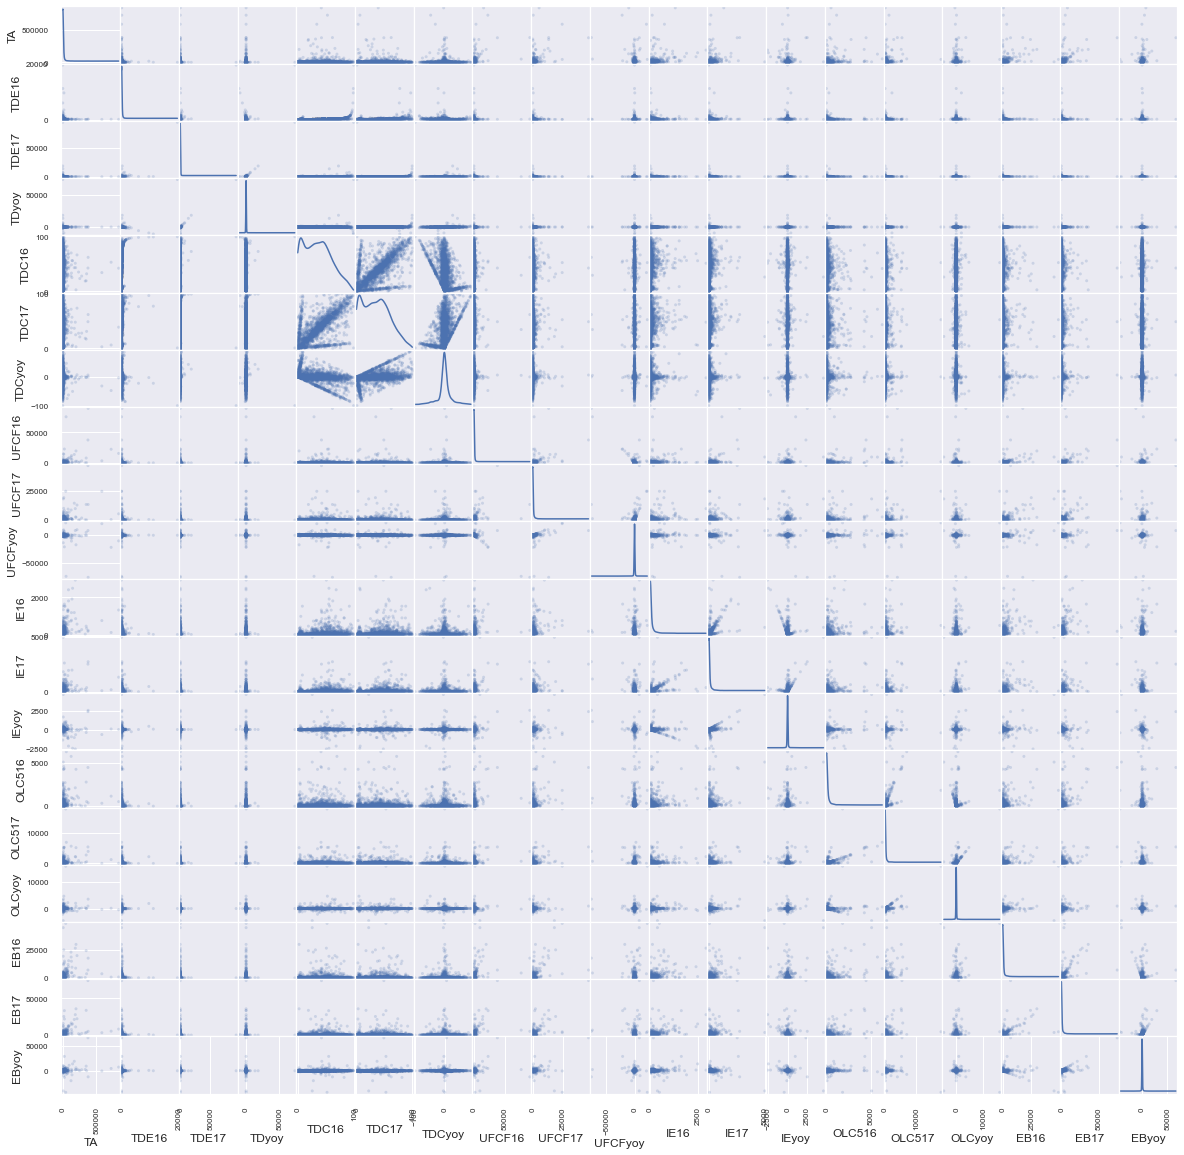

In [48]:
from pandas.plotting import scatter_matrix
scatter_matrix(X, alpha=0.2, figsize=(20, 20), diagonal='kde')
plt.show()

# Imputation Techniques

- Replace with 0, -1 (Dumb)

- Remove rows with missing values (only makes sense < 10% of missing values)

- Imputation with Mean, Median, Mode
    - median would make more sense if there are a lot of outlier values
    
- with cateogrical variables, you can add new 'unknown' value
- predicting the values w/ regression methods based on variables we do have data for
    - bias has to be smaller than the bias of omitting the variables all together
- stochastic regression imputation
    - similar to the above, but there is an error term added to preserve the variability of the data. Residual term (error) is normally distributed with a mean of zero and a variance equal to the variance of the predictor used for imputing
- can use KNN or random forests which can handle missing values
    - KNN scikit learn however requires all values to be present
    - RF is great because it handles non-linear relationships as well as missing values
- To correctly apply statistical missing data imputation and avoid data leakage, it is required that the statistics calculated for each column are calculated on the training dataset only, then applied to the train and test sets for each fold in the dataset

- multiple imputation: https://www.kaggle.com/residentmario/simple-techniques-for-missing-data-imputation


#### Random Forests don't require us to normalize our features

# Train Test Split

In [98]:
X_train, y_train, X_test, y_test = split_data(df_creditdata.drop("Default", axis=1), df_creditdata[["Default"]])

In [99]:
normalized_train_X,normalized_test_X, scaler = impute_dataset_with_mean(X_train, X_test)

In [104]:
unique, counts = np.unique(y_train, return_counts=True)
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(y_test, return_counts=True)
print (np.asarray((unique, counts)).T)

[[  0. 536.]
 [  1. 436.]]
[[0.000e+00 3.125e+03]
 [1.000e+00 1.100e+02]]


In [112]:
clf = RandomForestClassifier(random_state = 0, n_estimators=100, max_depth=4)
clf.fit(normalized_train_X, y_train)

predictions = clf.predict(normalized_test_X)
accuracy_score(y_test, predictions)
print(classification_report(y_test, predictions))
print (confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

         0.0       1.00      0.36      0.52      3125
         1.0       0.05      1.00      0.10       110

    accuracy                           0.38      3235
   macro avg       0.53      0.68      0.31      3235
weighted avg       0.97      0.38      0.51      3235

[[1112 2013]
 [   0  110]]


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model

#X_train, y_train, X_test, y_test
rf_random.fit(normalized_train_X,y_train)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.5s


In [117]:
rf_random.best_estimator_

RandomForestClassifier(max_depth=70, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=400)

In [121]:
clf = RandomForestClassifier(max_depth=70, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=400)

clf.fit(normalized_train_X, y_train)

predictions = clf.predict(normalized_test_X)
accuracy_score(y_test, predictions)

print(classification_report(y_test, predictions))
print (confusion_matrix(y_test, predictions))

fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
metrics.auc(fpr, tpr)

              precision    recall  f1-score   support

         0.0       1.00      0.27      0.42      3125
         1.0       0.05      1.00      0.09       110

    accuracy                           0.29      3235
   macro avg       0.52      0.63      0.26      3235
weighted avg       0.97      0.29      0.41      3235

[[ 838 2287]
 [   0  110]]


0.63408

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics

clf = LogisticRegression(random_state=0).fit(normalized_train_X, y_train)
predictions = clf.predict(normalized_test_X)

fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
metrics.auc(fpr, tpr)

0.8164072727272726

In [107]:
print(classification_report(y_test, predictions))
print (confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

         0.0       1.00      0.69      0.81      3125
         1.0       0.10      0.95      0.17       110

    accuracy                           0.70      3235
   macro avg       0.55      0.82      0.49      3235
weighted avg       0.97      0.70      0.79      3235

[[2148  977]
 [   6  104]]


# Imputations

In [ ]:
# imp_mean = SimpleImputer(strategy='median')
# imp_mean.fit(X_train)

# X_train_imputed_median = imp_mean.transform(X_train)
# X_test_imputed_median = imp_mean.transform(X_test)

In [ ]:
df_creditdata = df_creditdata[~df_creditdata.Default.isnull()]
df_creditdata = df_creditdata.drop(columns=['TDyoy'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)



In [ ]:
pd.DataFrame(clf.feature_importances_, X_train.columns, columns=['Feature Importance']).sort_values("Feature Importance", ascending=False)